In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/HISEA_flooding_dataset/


test  train  val


In [ ]:
# Colab setup (Python 3.10+ recommended)
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip -q install albumentations==1.4.7 opencv-python==4.10.0.84 rasterio==1.3.10 tifffile==2024.8.30 matplotlib==3.9.2 scikit-image==0.24.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 108.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/HISEA_flooding_dataset"
TRAIN_IMG_DIR = "train/image"
TRAIN_MASK_DIR = "train/label_1D"
VAL_IMG_DIR   = "val/image"
VAL_MASK_DIR  = "val/label_1D"
TEST_IMG_DIR  = "test/image"
TEST_MASK_DIR = "test/label_1D"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, glob

def make_pairs(root, img_subdir, mask_subdir):
    img_paths = glob.glob(os.path.join(root, img_subdir, "*"))
    mask_map = {os.path.splitext(os.path.basename(p))[0]: p
                for p in glob.glob(os.path.join(root, mask_subdir, "*"))}
    return [(img, mask_map.get(os.path.splitext(os.path.basename(img))[0]))
            for img in img_paths if os.path.splitext(os.path.basename(img))[0] in mask_map]

train_pairs = make_pairs(DATA_ROOT, TRAIN_IMG_DIR, TRAIN_MASK_DIR)
val_pairs   = make_pairs(DATA_ROOT, VAL_IMG_DIR, VAL_MASK_DIR)
test_pairs  = make_pairs(DATA_ROOT, TEST_IMG_DIR, TEST_MASK_DIR)

print(f"Train: {len(train_pairs)}, Val: {len(val_pairs)}, Test: {len(test_pairs)}")
assert len(train_pairs) and len(val_pairs) and len(test_pairs), "Make sure your subfolders and file names align."


Train: 1404, Val: 468, Test: 468


In [ ]:
import numpy as np, torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import rasterio

class FloodDataset(Dataset):
    def __init__(self, pairs, size=256, augment=False):
        self.pairs = pairs
        self.size = size
        self.augment = augment
        self.transform = A.Compose([
            A.RandomCrop(size, size, pad_if_needed=True) if augment else A.CenterCrop(size, size, pad_if_needed=True),
            A.HorizontalFlip(p=0.5 if augment else 0.0),
            A.VerticalFlip(p=0.5 if augment else 0.0),
        ])

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        img_fn, msk_fn = self.pairs[idx]
        with rasterio.open(img_fn) as src:
            img = src.read().astype(np.float32)
        for c in range(img.shape[0]):
            ch = img[c]
            p1, p99 = np.percentile(ch, (1, 99))
            img[c] = np.clip(ch, p1, p99)
            img[c] = (img[c] - img[c].mean()) / (ch.std() + 1e-6)
        with rasterio.open(msk_fn) as src:
            m = src.read(1)
            mask = (m > 0).astype(np.float32)
        img_hwc = img.transpose(1, 2, 0)
        mask_hwc = mask[..., None]
        aug = self.transform(image=img_hwc, mask=mask_hwc)
        img_aug = aug['image'].transpose(2,0,1)
        mask_aug = aug['mask'].squeeze().astype(np.float32)
        return torch.from_numpy(img_aug), torch.from_numpy(mask_aug[None])

train_ds = FloodDataset(train_pairs, size=256, augment=True)
val_ds   = FloodDataset(val_pairs,   size=256, augment=False)
test_ds  = FloodDataset(test_pairs,  size=256, augment=False)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:34: UserWarning: Argument 'pad_if_needed' is not valid and will be ignored.
  warn(


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

def conv_block(in_ch, out_ch, p_drop=0.2):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p_drop),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop):
      super().__init__()
      self.pool = nn.MaxPool2d(2)
      self.conv = conv_block(in_ch, out_ch, p_drop)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2)
        self.conv = conv_block(in_ch, out_ch, p_drop)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        dx = x2.size(3) - x1.size(3)
        dy = x2.size(2) - x1.size(2)
        x1 = F.pad(x1, [dx//2, dx-dx//2, dy//2, dy-dy//2])
        return self.conv(torch.cat([x2, x1], 1))

class BayesianUNet(nn.Module):
    def __init__(self, in_ch, base=32, p_drop=0.2):
        super().__init__()
        self.inc = conv_block(in_ch, base, p_drop)
        self.down1 = Down(base, base*2, p_drop)
        self.down2 = Down(base*2, base*4, p_drop)
        self.down3 = Down(base*4, base*8, p_drop)
        self.down4 = Down(base*8, base*8, p_drop)
        self.up1 = Up(base*8, base*4, p_drop)
        self.up2 = Up(base*4, base*2, p_drop)
        self.up3 = Up(base*2, base, p_drop)
        self.up4 = Up(base, base, p_drop)
        self.outc = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
in_ch = next(iter(train_loader))[0].shape[1]
model = BayesianUNet(in_ch).to(device)


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
bce = nn.BCEWithLogitsLoss()

import torch
import torch.nn as nn
import torch.nn.functional as F

# Dice Loss
class DiceLoss(nn.Module):
    def forward(self, logits, target, eps=1e-6):
        p = torch.sigmoid(logits)
        num = 2 * (p * target).sum((2, 3))
        den = p.sum((2, 3)) + target.sum((2, 3)) + eps
        return (1 - num / den).mean()

# Binary Cross Entropy
bce = nn.BCEWithLogitsLoss()

# Total loss
def total_loss(logits, y):
    bce_loss = bce(logits, y)
    dice_loss = DiceLoss()(logits, y)
    print(f"Dice Loss: {dice_loss.item():.6f}")
    print(f"BCE Loss: {bce_loss.item():.6f}")
    return 0.5 * bce_loss + 0.5 * dice_loss

# IoU metric
def iou_metric(logits, y, thr=0.5):
    p = (torch.sigmoid(logits) > thr).float()
    inter = (p * y).sum((2, 3))
    union = (p + y - p * y).sum((2, 3)) + 1e-6
    return (inter / union).mean().item()


In [ ]:
import torch.optim as optim
from tqdm.auto import tqdm

opt = optim.AdamW(model.parameters(), lr=1e-3)
best_val_iou = 0.0

for epoch in range(1, 11):
    model.train()
    tloss = 0
    total_bce, total_dice = 0, 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch} Train"):
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()

        logits = model(xb)

        # Compute separate losses
        bce_loss = bce(logits, yb)
        dice_loss = DiceLoss()(logits, yb)
        loss = 0.5 * bce_loss + 0.5 * dice_loss

        # Backpropagation
        loss.backward()
        opt.step()

        # Accumulate losses
        batch_size = xb.size(0)
        tloss += loss.item() * batch_size
        total_bce += bce_loss.item() * batch_size
        total_dice += dice_loss.item() * batch_size

    # Average losses per epoch
    tloss /= len(train_ds)
    avg_bce = total_bce / len(train_ds)
    avg_dice = total_dice / len(train_ds)

    # Validation
    model.eval()
    vloss = 0; viou = 0
    val_bce_total, val_dice_total = 0, 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)

            val_bce_loss = bce(logits, yb)
            val_dice_loss = DiceLoss()(logits, yb)
            val_loss = 0.5 * val_bce_loss + 0.5 * val_dice_loss

            batch_size = xb.size(0)
            vloss += val_loss.item() * batch_size
            viou += iou_metric(logits, yb) * batch_size
            val_bce_total += val_bce_loss.item() * batch_size
            val_dice_total += val_dice_loss.item() * batch_size

    # Average validation losses
    vloss /= len(val_ds)
    viou /= len(val_ds)
    avg_val_bce = val_bce_total / len(val_ds)
    avg_val_dice = val_dice_total / len(val_ds)

    # Print summary
    print(f"Epoch {epoch} → Train Loss: {tloss:.4f} | Val Loss: {vloss:.4f} | Val IoU: {viou:.4f}")
    print(f"        → Train BCE: {avg_bce:.4f} | Train Dice: {avg_dice:.4f}")
    print(f"        → Val BCE: {avg_val_bce:.4f} | Val Dice: {avg_val_dice:.4f}")

    # Save best model
    if viou > best_val_iou:
        best_val_iou = viou
        torch.save(model.state_dict(), "/content/best_bayesian_unet.pt")
        print(" New best model saved.")


Epoch 1 Train:   0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1 → Train Loss: 0.5178 | Val Loss: 0.5896 | Val IoU: 0.3146
        → Train BCE: 0.4812 | Train Dice: 0.5544
        → Val BCE: 0.5302 | Val Dice: 0.6490
 New best model saved.


Epoch 2 Train:   0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Exception ig

Epoch 2 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Exception ig

Epoch 2 → Train Loss: 0.4801 | Val Loss: 0.4412 | Val IoU: 0.5419
        → Train BCE: 0.4551 | Train Dice: 0.5051
        → Val BCE: 0.4255 | Val Dice: 0.4569
 New best model saved.


Epoch 3 Train:   0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae9784d2a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self.

Epoch 3 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 3 → Train Loss: 0.4690 | Val Loss: 0.4064 | Val IoU: 0.5496
        → Train BCE: 0.4504 | Train Dice: 0.4876
        → Val BCE: 0.3658 | Val Dice: 0.4470
 New best model saved.


Epoch 4 Train:   0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 4 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 4 → Train Loss: 0.4346 | Val Loss: 0.4077 | Val IoU: 0.5387
        → Train BCE: 0.4138 | Train Dice: 0.4554
        → Val BCE: 0.3711 | Val Dice: 0.4443


Epoch 5 Train:   0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 5 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 5 → Train Loss: 0.4293 | Val Loss: 0.3804 | Val IoU: 0.6045
        → Train BCE: 0.4122 | Train Dice: 0.4464
        → Val BCE: 0.3584 | Val Dice: 0.4025
 New best model saved.


Epoch 6 Train:   0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

Epoch 6 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 6 → Train Loss: 0.4231 | Val Loss: 0.3842 | Val IoU: 0.5717
        → Train BCE: 0.4066 | Train Dice: 0.4397
        → Val BCE: 0.3623 | Val Dice: 0.4061


Epoch 7 Train:   0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 7 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 7 → Train Loss: 0.4004 | Val Loss: 0.3561 | Val IoU: 0.6136
        → Train BCE: 0.3829 | Train Dice: 0.4179
        → Val BCE: 0.3483 | Val Dice: 0.3638
 New best model saved.


Epoch 8 Train:   0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Exception ig

Epoch 8 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Exception ig

Epoch 8 → Train Loss: 0.3837 | Val Loss: 0.3583 | Val IoU: 0.6025
        → Train BCE: 0.3698 | Train Dice: 0.3977
        → Val BCE: 0.3466 | Val Dice: 0.3700


Epoch 9 Train:   0%|          | 0/351 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ae9784d2a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
^^^^^^^^^^/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be 

Epoch 9 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 9 → Train Loss: 0.3792 | Val Loss: 0.3654 | Val IoU: 0.5950
        → Train BCE: 0.3637 | Train Dice: 0.3948
        → Val BCE: 0.3569 | Val Dice: 0.3738


Epoch 10 Train:   0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 10 Val:   0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 10 → Train Loss: 0.3752 | Val Loss: 0.3480 | Val IoU: 0.6185
        → Train BCE: 0.3628 | Train Dice: 0.3876
        → Val BCE: 0.3376 | Val Dice: 0.3584
 New best model saved.


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


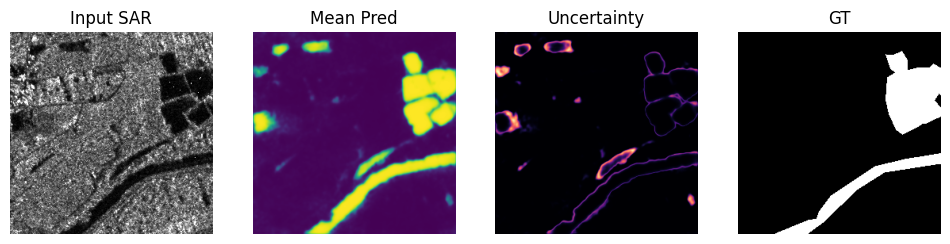

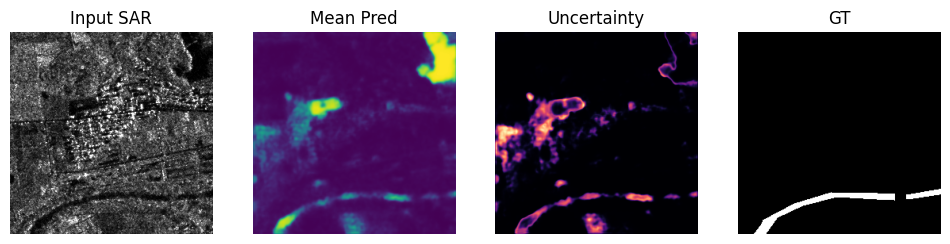

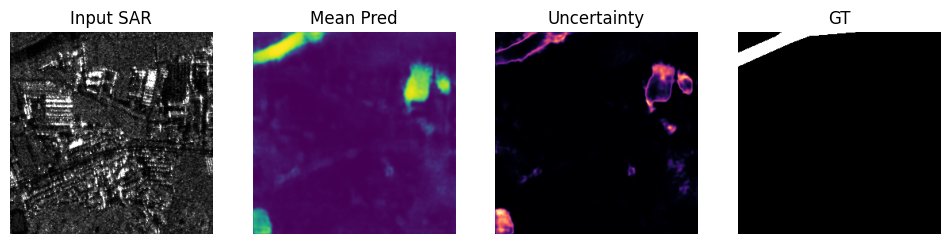

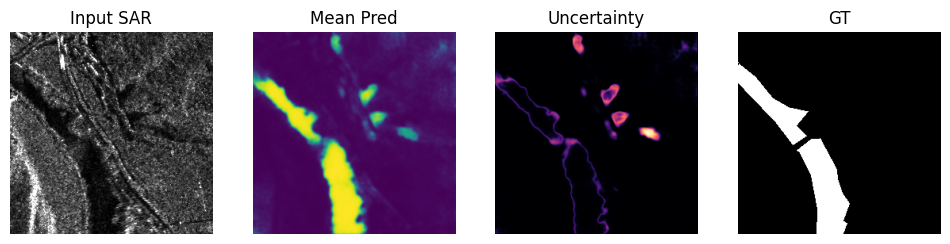

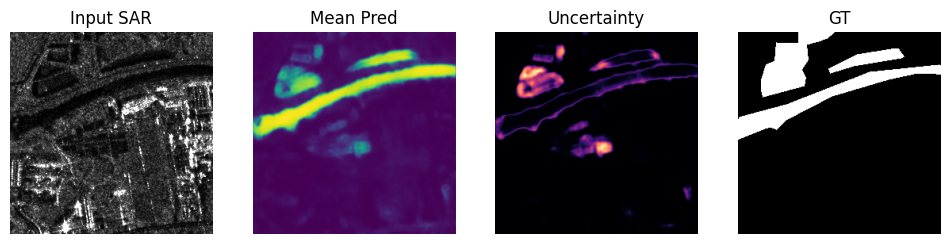

In [ ]:
import matplotlib.pyplot as plt

def enable_mc_dropout(m):
    for module in m.modules():
        if isinstance(module, nn.Dropout2d): module.train()

@torch.no_grad()
def mc_predict(model, x, T=20):
    model.eval()
    enable_mc_dropout(model)
    preds = torch.stack([torch.sigmoid(model(x)) for _ in range(T)], dim=0)
    return preds.mean(0), preds.var(0)

# Load best model
model.load_state_dict(torch.load("/content/best_bayesian_unet.pt", map_location=device))

# Visualize some test results
for i, (xb, yb) in enumerate(test_loader):
    xb, yb = xb.to(device), yb.to(device)
    mean_p, var_p = mc_predict(model, xb, T=20)
    im = xb[0,0].cpu().numpy()
    pred = mean_p[0,0].cpu().numpy()
    unc = var_p[0,0].cpu().numpy()
    gt = yb[0,0].cpu().numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.title("Input SAR"); plt.imshow(im, cmap='gray'); plt.axis('off')
    plt.subplot(1,4,2); plt.title("Mean Pred"); plt.imshow(pred, cmap='viridis'); plt.axis('off')
    plt.subplot(1,4,3); plt.title("Uncertainty"); plt.imshow(unc, cmap='magma'); plt.axis('off')
    plt.subplot(1,4,4); plt.title("GT"); plt.imshow(gt, cmap='gray'); plt.axis('off')
    plt.show()
    if i >= 4: break #examole for 5 samples


In [ ]:
%%writefile app.py
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import rasterio
import albumentations as A
import os

# Define the UNet model architecture (copy the relevant classes from your notebook)
def conv_block(in_ch, out_ch, p_drop=0.2):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p_drop),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop):
      super().__init__()
      self.pool = nn.MaxPool2d(2)
      self.conv = conv_block(in_ch, out_ch, p_drop)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch1, in_ch2, out_ch, p_drop):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch1, in_ch1 // 2, 2, stride=2)
        self.conv = conv_block(in_ch2 + in_ch1 // 2, out_ch, p_drop)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        # Corrected padding
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        return self.conv(torch.cat([x2, x1], dim=1))

class BayesianUNet(nn.Module):
    def __init__(self, in_ch, base=32, p_drop=0.2):
        super().__init__()
        self.inc = conv_block(in_ch, base, p_drop)
        self.down1 = Down(base, base*2, p_drop)
        self.down2 = Down(base*2, base*4, p_drop)
        self.down3 = Down(base*4, base*8, p_drop)
        self.down4 = Down(base*8, base*8, p_drop)
        self.up1 = Up(base*8, base*8, base*4, p_drop)
        self.up2 = Up(base*4, base*4, base*2, p_drop)
        self.up3 = Up(base*2, base*2, base, p_drop)
        self.up4 = Up(base, base, base, p_drop)
        self.outc = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

# Load the trained model
@st.cache_resource
def load_model():
    model = BayesianUNet(in_ch=1) # Assuming single channel input
    model.load_state_dict(torch.load("bayesian_unet_model.pt", map_location=torch.device('cpu')))
    model.eval()
    return model

model = load_model()

# Streamlit app title
st.title("Flood Detection using Bayesian UNet")

# File uploader
uploaded_file = st.file_uploader("Upload a SAR image (TIF)", type="tif")

if uploaded_file is not None:
    # Save the uploaded file temporarily
    with open("temp_image.tif", "wb") as f:
        f.write(uploaded_file.getbuffer())

    # Preprocess the image and perform inference (Implement this part)
    def preprocess_and_predict(image_path, model, size=256):
        with rasterio.open(image_path) as src:
            img = src.read().astype(np.float32)
        # Add preprocessing steps here similar to your dataset class
        # Example: normalization, clipping, resizing/cropping
        for c in range(img.shape[0]):
            ch = img[c]
            p1, p99 = np.percentile(ch, (1, 99))
            img[c] = np.clip(ch, p1, p99)
            img[c] = (img[c] - img[c].mean()) / (ch.std() + 1e-6)

        # Assuming single channel for now, adjust if multi-channel
        img = img[0, :, :] # Take the first channel

        # Apply the same transformations as during training/validation
        transform = A.Compose([
            A.CenterCrop(size, size, pad_if_needed=True),
        ])
        img_hwc = img[..., None]
        augmented = transform(image=img_hwc)
        img_aug = augmented['image'].transpose(2,0,1) # Channel first

        # Convert to tensor and add batch dimension
        input_tensor = torch.from_numpy(img_aug).unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            # Enable MC Dropout for uncertainty estimation if needed
            # enable_mc_dropout(model)
            # For a single prediction without MC dropout uncertainty:
            logits = model(input_tensor)
            prediction = torch.sigmoid(logits).squeeze().cpu().numpy()

        return prediction #, uncertainty_map (if using MC dropout)


    prediction = preprocess_and_predict("temp_image.tif", model) #, uncertainty_map

    # Display the results
    st.image(uploaded_file, caption="Uploaded SAR Image", use_column_width=True)
    st.image(prediction, caption="Flood Prediction", use_column_width=True, cmap='viridis')
    # if uncertainty_map is not None:
    #     st.image(uncertainty_map, caption="Uncertainty Map", use_column_width=True, cmap='magma')

    # Clean up temporary file
    os.remove("temp_image.tif")

Overwriting app.py


In [ ]:
import torch

# Save the trained model
torch.save(model.state_dict(), "/content/bayesian_unet_model.pt")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

def conv_block(in_ch, out_ch, p_drop=0.2):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p_drop),
        nn.Conv2d(out_ch, out_ch, 3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, p_drop):
      super().__init__()
      self.pool = nn.MaxPool2d(2)
      self.conv = conv_block(in_ch, out_ch, p_drop)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch1, in_ch2, out_ch, p_drop):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch1, in_ch1 // 2, 2, stride=2)
        self.conv = conv_block(in_ch2 + in_ch1 // 2, out_ch, p_drop)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        return self.conv(torch.cat([x2, x1], dim=1))

class BayesianUNet(nn.Module):
    def __init__(self, in_ch, base=32, p_drop=0.2):
        super().__init__()
        self.inc = conv_block(in_ch, base, p_drop)
        self.down1 = Down(base, base*2, p_drop)
        self.down2 = Down(base*2, base*4, p_drop)
        self.down3 = Down(base*4, base*8, p_drop)
        self.down4 = Down(base*8, base*8, p_drop)
        self.up1 = Up(base*8, base*8, base*4, p_drop)
        self.up2 = Up(base*4, base*4, base*2, p_drop)
        self.up3 = Up(base*2, base*2, base, p_drop)
        self.up4 = Up(base, base, base, p_drop)
        self.outc = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.outc(x)

# Create model
in_ch = next(iter(train_loader))[0].shape[1]
model = BayesianUNet(in_ch).cuda()

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


**Deploying on Streamlit Cloud:**

1.  **Put your code in a GitHub repository:**
    *   Create a new public GitHub repository.
    *   Add your `app.py` file, your trained model file (`bayesian_unet_model.pt`), and a `requirements.txt` file to the repository. The `requirements.txt` file should list all the Python packages your app depends on (e.g., `streamlit`, `torch`, `numpy`, `rasterio`, `albumentations`, `opencv-python`, `tifffile`, `matplotlib`, `scikit-image`).

2.  **Go to Streamlit Cloud:**
    *   Sign up or log in to Streamlit Cloud ([https://streamlit.io/cloud](https://streamlit.io/cloud)).

3.  **Deploy a new app:**
    *   Click on the "Deploy an app" button.
    *   Select "From existing repo".
    *   Connect your GitHub account if you haven't already.
    *   Choose the repository you created.
    *   Specify the branch (usually `main` or `master`).
    *   Set the main file path to `/app.py`.
    *   Click "Deploy!".

Streamlit Cloud will then build and deploy your application.